In [5]:
import warnings
import itertools
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [7]:
#example dataset given by eaze
data = pd.read_csv("hourly_volume.csv")

In [27]:
data.head()

,order_hour,num_orders
0,2016-07-04 00:00:00,0
1,2016-07-04 01:00:00,0
2,2016-07-04 02:00:00,0
3,2016-07-04 03:00:00,0
4,2016-07-04 04:00:00,0


In [36]:
len(data)

1200

In [14]:
#check if there's missing value
#there isn't
data[data['num_orders'].isnull() == True]

,order_hour,num_orders


In [39]:
#or
data.isnull().sum()

num_orders    0
dtype: int64

In [24]:
#parse strings to datetime type
data['order_hour'] = pd.to_datetime(data['order_hour'], infer_datetime_format=True)

In [26]:
data.head()

,order_hour,num_orders
0,2016-07-04 00:00:00,0
1,2016-07-04 01:00:00,0
2,2016-07-04 02:00:00,0
3,2016-07-04 03:00:00,0
4,2016-07-04 04:00:00,0


In [28]:
data = data.set_index(['order_hour'])

In [29]:
data.head()

,num_orders
order_hour,
2016-07-04 00:00:00,0
2016-07-04 01:00:00,0
2016-07-04 02:00:00,0
2016-07-04 03:00:00,0
2016-07-04 04:00:00,0


In [38]:
#code for slicing dates
len(data['2016-07-08':'2016-07-15'])

192

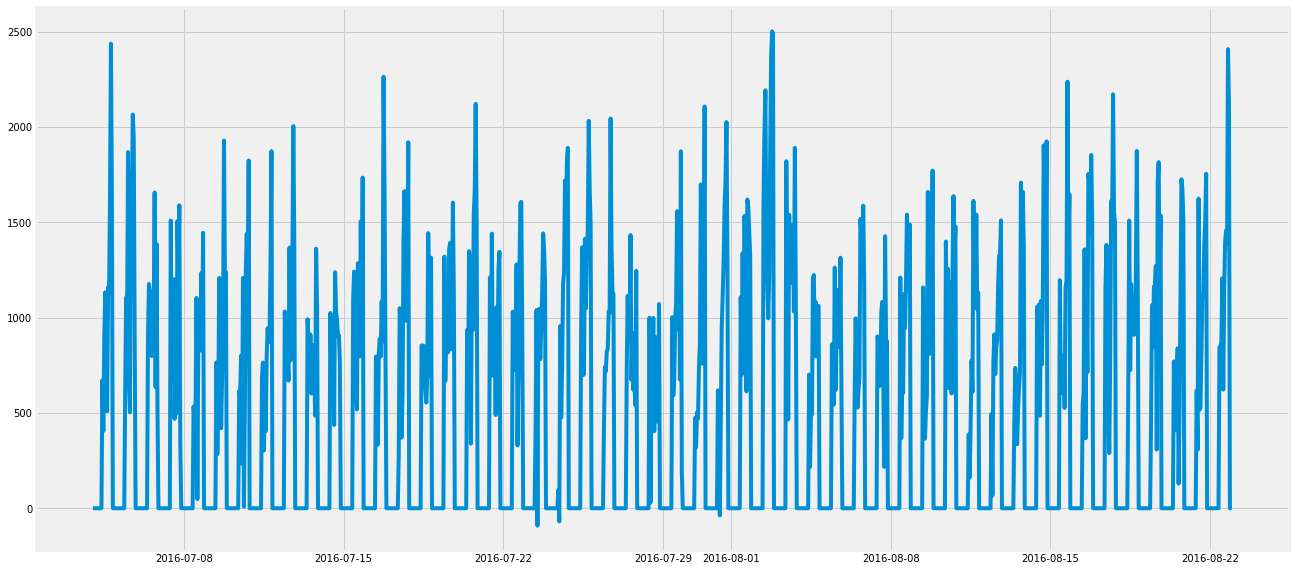

In [35]:
plt.figure(figsize=(20,10))
plt.plot(data)

In [48]:
#finding parameters for ARIMA
#define p,d,q to take any values between 0,3 (exclusive to 3)
p = d = q = range(0,3)

In [49]:
#generate all difference combinations of p,d,q triplets
pdq = list(itertools.product(p,d,q))

In [50]:
pdq

[(0, 0, 0),
 (0, 0, 1),
 (0, 0, 2),
 (0, 1, 0),
 (0, 1, 1),
 (0, 1, 2),
 (0, 2, 0),
 (0, 2, 1),
 (0, 2, 2),
 (1, 0, 0),
 (1, 0, 1),
 (1, 0, 2),
 (1, 1, 0),
 (1, 1, 1),
 (1, 1, 2),
 (1, 2, 0),
 (1, 2, 1),
 (1, 2, 2),
 (2, 0, 0),
 (2, 0, 1),
 (2, 0, 2),
 (2, 1, 0),
 (2, 1, 1),
 (2, 1, 2),
 (2, 2, 0),
 (2, 2, 1),
 (2, 2, 2)]

In [51]:
#generate all difference combinations of seasonal p,d,q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 0, 2, 12)
SARIMAX: (0, 0, 2) x (0, 1, 0, 12)
SARIMAX: (0, 0, 2) x (0, 1, 1, 12)


In [53]:
warnings.filterwarnings("ignore") # specify to ignore warning messages

In [ ]:
#grid search - automation of finding parameters
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(data,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

In [ ]:
#use the best (lowest AIC) parameters
#to fit the ARIMA time series model
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

In [ ]:
#run model diagnostics
results.plot_diagnostics(figsize=(15, 12))
plt.show()

In [ ]:
#predict
# Get forecast 500 steps ahead in future
pred_uc = results.get_forecast(steps=500)

# Get confidence intervals of forecasts
pred_ci = pred_uc.conf_int()

In [ ]:
ax = y.plot(label='observed', figsize=(20, 15))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Volume')

plt.legend()
plt.show()